In [1]:
# Import APIs
import os
import mne
import numpy as np
import scipy.io # To load .mat files
import matplotlib.pyplot as plt
import tensorflow as tf # I used Tensorflow-GPU 2.0.
import pandas as pd

from sklearn.metrics import accuracy_score

# Fix seeds
np.random.seed(seed=951014)
tf.random.set_seed(seed=951014)

# Control GPU consumption
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "True"

In [2]:
# Define load_dataset function
def load_dataset(sbj_idx: int, num_avg_trials: int, call_train : bool):
    if sbj_idx>30 or sbj_idx<1:
        raise ValueError("We have Subject 1 to 30.")
    if num_avg_trials>10 or num_avg_trials<1:
        raise ValueError("We have at most 10 iterations for each trial.")
            
    # Define your own data path
    path = "/define/your/own/path/UNIST_P300/TV_EP/"
    
    if call_train == True:
        name = (f"EP_train_sub{sbj_idx}.mat", "EP")
    else:
        name = (f"EP_test_sub{sbj_idx}.mat", "EP_t")
    
    # Load .mat files
    raw = scipy.io.loadmat(path + name[0])[name[1]]
    
    # Extract data and label
    X, Y = raw["data"][0][0], raw["target"][0][0]
    
    # To retain memory
    del raw
    
    # Reordering the dimensions
    # Data: [stimulus x trial x channel x timepoint x iteration]
    X = np.moveaxis(np.moveaxis(X, -1, 0), -1, 0)
    
    # Averaging
    X = np.mean(X[..., :num_avg_trials], axis=-1)

    # Remove baseline
    X = X[..., 100:]
    
    # To squeeze the dimension
    Y = np.squeeze(Y)
    return X, Y

In [3]:
# Define MSNN
class MSNN(tf.keras.Model):
    tf.keras.backend.set_floatx("float64")
    def __init__(self, num_channels):
        super(MSNN, self).__init__()
        self.C = num_channels
        self.fs = 500

        # Regularizer
        self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

        # Activation functions
        self.activation = tf.keras.layers.LeakyReLU()
        self.softmax = tf.keras.layers.Softmax()
        
        # Define convolutions
        conv = lambda D, kernel : tf.keras.layers.Conv2D(D, kernel, kernel_regularizer=self.regularizer)
        sepconv = lambda D, kernel : tf.keras.layers.SeparableConv2D(D, kernel, padding="same",
                                                                    depthwise_regularizer=self.regularizer,
                                                                    pointwise_regularizer=self.regularizer)
        
        # Spectral convoltuion
        self.conv0 = conv(4, (1, int(self.fs/2)))
        
        # Spatio-temporal convolution
        self.conv1t = sepconv(16, (1, 20))
        self.conv1s = conv(16, (self.C, 1))
        
        self.conv2t = sepconv(32, (1, 10))
        self.conv2s = conv(32, (self.C, 1))
        
        self.conv3t = sepconv(64, (1, 5))
        self.conv3s = conv(64, (self.C, 1))

        # Flatteninig
        self.flatten = tf.keras.layers.Flatten()

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        # Decision making
        self.dense = tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=self.regularizer)

    def call(self, x):
        # Extract spatio-spectral-temporal features
        x = self.activation(self.conv0(x)) # [batch, channel, 51, 4]
        
        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))
        
        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        input_feature = x # To estimate activation pattern
        f3 = self.activation(self.conv3s(x))
        
        feature = tf.concat((f1, f2, f3), -1) # Concat
        feature = tf.math.reduce_mean(feature, -2) # GAP
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        prob = self.dense(feature)
        return tf.squeeze(prob), input_feature

In [4]:
# Define utility function
def gradient(model, inputs, labels):
    with tf.GradientTape() as tape:
        y_hat, _ = model(inputs)
        loss = tf.keras.losses.binary_crossentropy(labels, y_hat)
        
    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

In [5]:
# Define experiment conducting function
class experiment():
    def __init__(self, sbj_idx, num_avg_trials):
        self.sbj_idx = sbj_idx
        self.num_avg_trials = num_avg_trials
        
        # Load dataset
        self.train_X, self.train_Y = load_dataset(self.sbj_idx, self.num_avg_trials, True)
        self.train_Y -= 1
        
        self.num_batch_iter = self.train_X.shape[1]
        self.num_channels = self.train_X.shape[2]
        
        # Randomize the training dataset
        rand_idx = np.random.permutation(self.num_batch_iter)
        self.train_X, self.train_Y = self.train_X[:, rand_idx, ...], self.train_Y[rand_idx, ]
        
        # Task-classification to target/nontarget-classification
        one_hot = lambda target : np.eye(np.unique(target, axis=0).shape[0])[target]
        self.train_Y = one_hot(self.train_Y)
        
        # Learning schedules
        self.init_LR = 1e-4
        self.num_epochs = 15
        self.num_batch = 4
        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.init_LR)
        
    def training(self):
        print(f"Start training, Subject: {self.sbj_idx}, Averaged trials: {self.num_avg_trials}")
        
        # Call MSNN
        msnn = MSNN(self.num_channels)
        
        # To record the loss curve
        loss_report = []
        for epoch in range(self.num_epochs):
            loss_per_epoch = 0
            
            for batch in range(self.num_batch_iter):
                # Sample minibatch
                xb = np.expand_dims(self.train_X[:, batch, ...], -1)
                yb = self.train_Y[batch, :]

                # Estimate loss
                loss, grads = gradient(msnn, xb, yb)
                
                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, msnn.trainable_variables))
                loss_report.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)
            
            loss_per_epoch /= self.num_batch_iter
            
            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")


        test_X, test_Y = load_dataset(self.sbj_idx, self.num_avg_trials, False)
        test_Y -= 1
        # Testing
        task_pred = np.zeros(shape=(test_X.shape[0], test_X.shape[1]))
        for batch in range(test_X.shape[1]):
            temp_data = np.expand_dims(test_X[:, batch, ...], -1)
            task_pred[..., batch], _ = msnn(temp_data)

        task_pred = np.argmax(task_pred, axis=0)
        test_acc = accuracy_score(test_Y, task_pred)
        print(f"Testing accuracy {test_acc:>.04f}")
        return loss_report, test_acc

In [6]:
%%time
# Experiments
repetitions = 10

exp = experiment(19, repetitions)
report, _ = exp.training()

Start training, Subject: 19, Averaged trials: 10
Iteration 1, Training Loss 0.5764
Iteration 2, Training Loss 0.3367
Iteration 3, Training Loss 0.1558
Iteration 4, Training Loss 0.0745
Iteration 5, Training Loss 0.0432
Iteration 6, Training Loss 0.0283
Iteration 7, Training Loss 0.0195
Iteration 8, Training Loss 0.0137
Iteration 9, Training Loss 0.0096
Iteration 10, Training Loss 0.0067
Iteration 11, Training Loss 0.0045
Iteration 12, Training Loss 0.0029
Iteration 13, Training Loss 0.0018
Iteration 14, Training Loss 0.0011
Iteration 15, Training Loss 0.0006
Testing accuracy 1.0000
CPU times: user 18.9 s, sys: 711 ms, total: 19.6 s
Wall time: 20.4 s


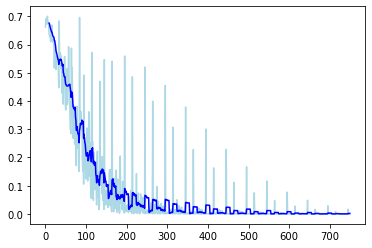

In [7]:
# Plot loss curve
report = pd.DataFrame(np.array(report))
plt.plot(report[0], "lightblue")
plt.plot(report[0].rolling(10).mean(), "b")
plt.show()